In [3]:
import glob
import rasterio
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
from datetime import datetime, time
from scipy.signal import savgol_filter
from xcube.core.dsio import open_cube
from xcube.core.geom import mask_dataset_by_geometry
# import pingouin as pg
import scipy

import pymc as pm
import arviz as az
print(f"Running on PyMC v{pm.__version__}")
import warnings
warnings.filterwarnings("ignore")

Running on PyMC v5.8.0


### Load Satellite Derived Vegetation Index and Land Surface Temparature Data Cubes 

In [ ]:
cube_dat1 = open_cube('/media/Cheetah_2/ZARR_files/Auchencorth_LST_sharp_Day_all_stack.zarr/', format_name='zarr')
cube_dat2 = open_cube('/media/Cheetah_2/ZARR_files/Auchencorth_T30UVG_all_stack.zarr/', format_name='zarr')
cube_dat3 = open_cube('/media/Cheetah_2/ZARR_files/Cairngorms_LST_sharp_Day_all_stack.zarr/', format_name='zarr')
cube_dat4 = open_cube('/media/Cheetah_2/ZARR_files/Cairngorms_T30VVJ_all_stack.zarr/', format_name='zarr')

In [ ]:
cube_dat1

,Array,Chunk
Bytes,18.62 GiB,4.77 MiB
Shape,"(94, 5491, 9683)","(6, 344, 606)"
Count,4097 Tasks,4096 Chunks
Type,float32,numpy.ndarray


### Load Shapefiles for our area of interest

In [5]:
footPrint = gpd.read_file('AOI/footprint_1km.shp')
footPrint

f1 = footPrint[footPrint.Location=='Auchencorth'].geometry.values[0]
cr1 = mask_dataset_by_geometry(cube_dat1, f1)

subsel = cr1.sel(time='2016')
subsel1 = subsel.isel(time=(subsel.time.dt.month.isin([4,5,6])))
subsel1.LST.plot.imshow(col='time', cmap='viridis', col_wrap=5)

### Extract and aggregate pixels values from AOI using the AOI footprints

In [7]:
f1 = footPrint[footPrint.Location=='Cairngorms'].geometry.values[0]
f2 = footPrint[footPrint.Location=='Auchencorth'].geometry.values[0]

Auch_lst = mask_dataset_by_geometry(cube_dat1, f2).load().mean(dim=['lat', 'lon']).to_dataframe()
Auch_ind = mask_dataset_by_geometry(cube_dat2, f2).load().mean(dim=['lat', 'lon']).to_dataframe()
Cairn_lst = mask_dataset_by_geometry(cube_dat3, f1).load().mean(dim=['lat', 'lon']).to_dataframe()
Cairn_ind = mask_dataset_by_geometry(cube_dat4, f1).load().mean(dim=['lat', 'lon']).to_dataframe()


In [28]:
Auch_all = Auch_ind.merge(Auch_lst, on='time')
Cairn_all = Cairn_ind.merge(Cairn_lst, on='time')

In [29]:
Auch_all

,MWI,MWIre,NDVI,NDWI,LST
time,,,,,
2016-01-14,NaN,NaN,NaN,NaN,NaN
2016-03-14,3.056036,1.125862,0.534002,0.360912,12.208019
2016-05-03,4.275239,1.567090,0.684703,0.560558,NaN
2016-05-23,2.022175,0.675708,0.493699,0.481884,NaN
2016-06-02,3.892382,1.304377,0.637636,0.409027,23.559870
...,...,...,...,...,...
2022-03-08,2.735894,1.070472,0.516521,0.313189,5.303551
2022-03-18,2.960867,1.151981,0.530821,0.362039,NaN
2022-03-23,2.686460,1.034901,0.497686,0.297703,15.573832


### Explore extracted pixel data with correlation plots

<AxesSubplot:title={'center':'Auchencorth'}>

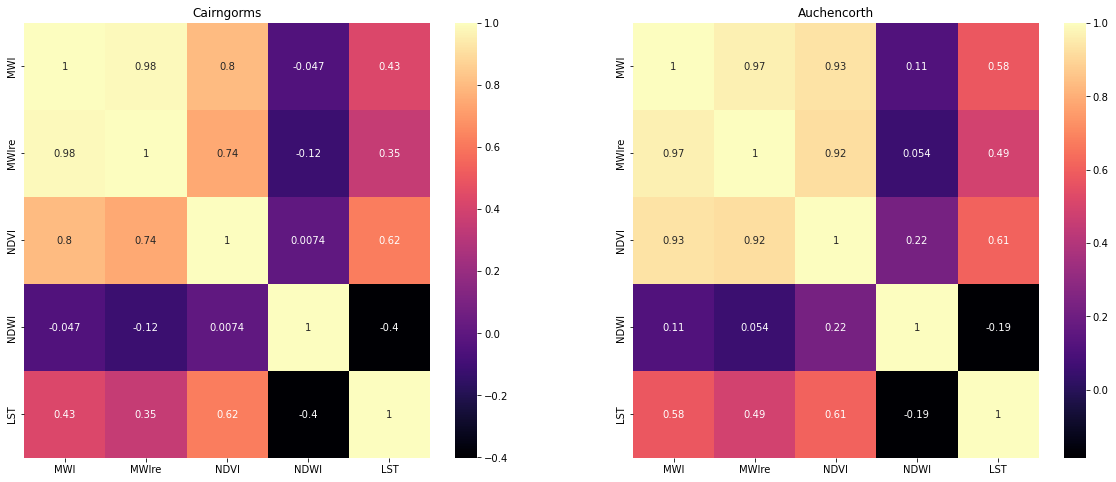

In [47]:
c_corr = Cairn_all.corr()
a_corr = Auch_all.corr()
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

axs[0].set_title('Cairngorms')
sns.heatmap(c_corr, cmap='magma', annot=True, ax=axs[0])
axs[1].set_title('Auchencorth')
sns.heatmap(a_corr, cmap='magma', annot=True,  ax=axs[1])

<AxesSubplot:title={'center':'Auchencorth'}>

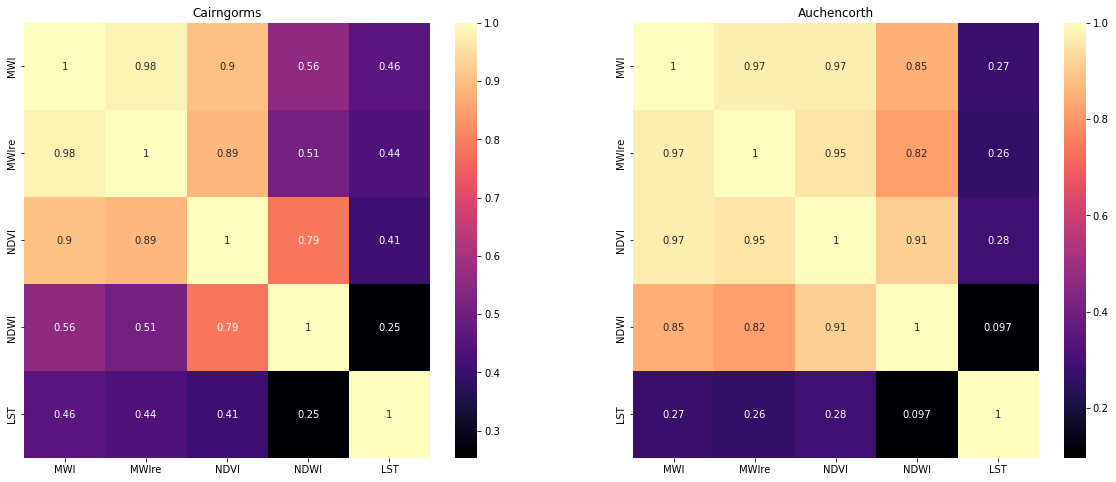

In [48]:
c_corr = Cairn_all.iloc[Cairn_all.index.month.isin([5,6,7,8])].corr()
a_corr = Auch_all.iloc[Auch_all.index.month.isin([5,6,7,8])].corr()
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

axs[0].set_title('Cairngorms')
sns.heatmap(c_corr, cmap='magma', annot=True, ax=axs[0])
axs[1].set_title('Auchencorth')
sns.heatmap(a_corr, cmap='magma', annot=True,  ax=axs[1])

### Load the ground measured flux tower data

In [49]:
gppAuch1 = pd.read_csv('NEE_UK/Auchencorth_flux_GPP.csv', parse_dates=['Date'])
gppCairn = pd.read_csv('NEE_UK/Cairngorms_flux_GPP.csv', parse_dates=['Date'])
gppAuch1 = gppAuch1.rename(columns={'Date':'time'})
gppCairn = gppCairn.rename(columns={'Date':'time'})

In [52]:
gppAuch1

,time,NEE,NEE_unc,VPD,TA,SWIN,GPP,RECO
0,2012-01-01,0.4896,0.2151,0.1063,4.2831,18.3020,0.382930,0.872530
1,2012-01-02,0.4896,0.2151,0.1040,1.5760,17.2592,0.382397,0.871997
2,2012-01-03,0.4896,0.2151,0.0825,2.8754,9.9256,0.382651,0.872251
3,2012-01-04,0.4277,0.2100,0.0486,3.0920,5.9513,0.444594,0.872294
4,2012-01-05,0.0303,0.0915,0.1395,2.9171,28.9512,0.841959,0.872259
...,...,...,...,...,...,...,...,...
2917,2019-12-27,1.0152,0.1242,0.0005,6.5750,8.6236,-0.305655,0.709545
2918,2019-12-28,1.2458,0.1256,0.0004,8.4442,12.5664,-0.535943,0.709857
2919,2019-12-29,0.8740,0.1159,0.0001,8.4019,19.9258,-0.164150,0.709850
2920,2019-12-30,1.0030,0.1322,0.0003,5.7712,4.4907,-0.293588,0.709412


In [33]:
gppAuch = pd.read_csv('./UK-AMo_NEE_GF_met_2017-2021.csv')
gppAuch['Time_Stamp'] = pd.to_datetime(gppAuch.Time_Stamp, dayfirst=True)
gppAuch['time'] = gppAuch['Time_Stamp'].dt.date
gppAuch = gppAuch.replace(-9999.00, np.nan)

<AxesSubplot:>

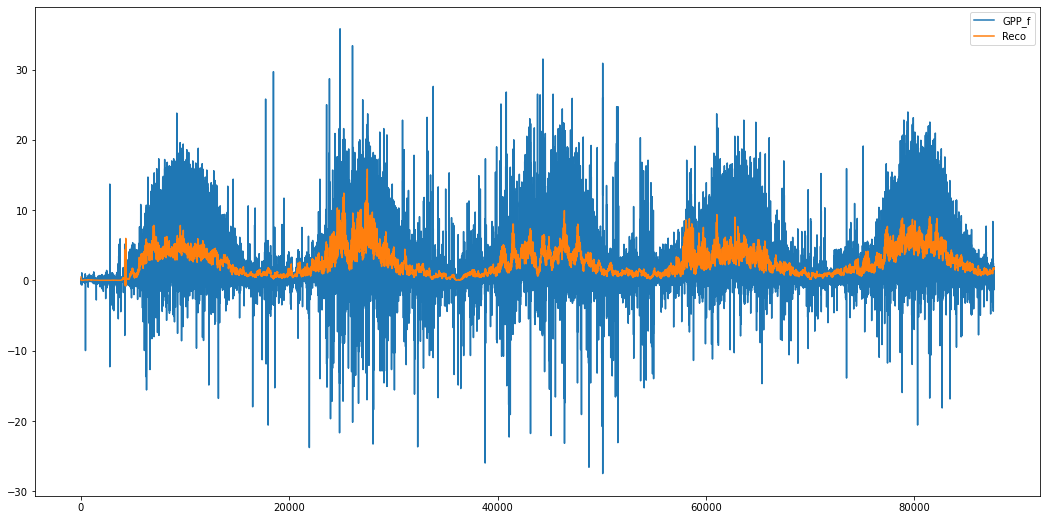

In [18]:
gppAuch[['GPP_f','Reco']].plot(figsize=(18, 9))

In [35]:
gppAuch_sub = gppAuch[gppAuch.Time_Stamp.dt.time.isin([time(11,0,0), time(11,30,0), time(12,0,0)])]
gppAuch_sub1 = gppAuch_sub.groupby('time').mean().reset_index()
gppAuch_sub1['time'] = pd.to_datetime(gppAuch_sub1['time'])


<AxesSubplot:xlabel='time'>

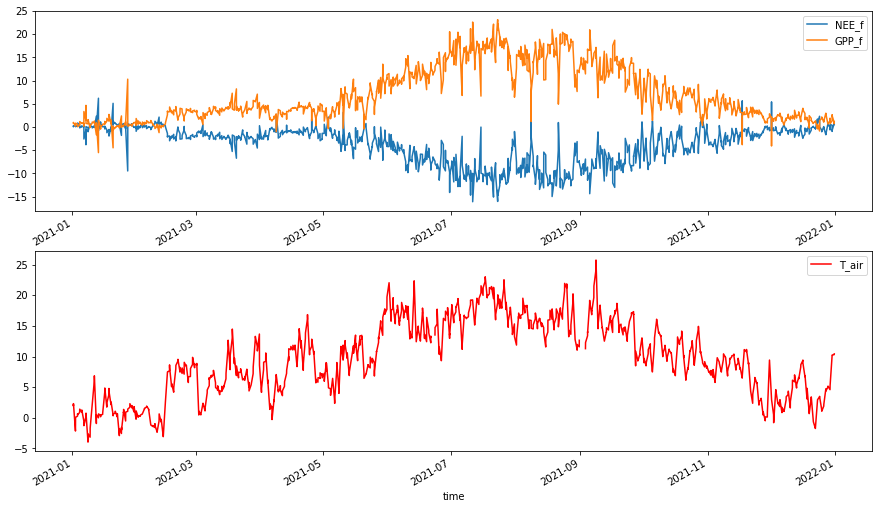

In [25]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15,9))
t2.loc[:,['time','NEE_f','GPP_f']].plot(x='time', ax=axs[0])
t2.loc[:,['time','T_air']].plot(x='time', c='r', ax=axs[1])

### Merge ground measured with extracted satellite data

In [38]:
Auch_all1 = Auch_all.merge(gppAuch_sub1.loc[:,['time','NEE_f','GPP_f','T_air']], on='time')

In [39]:
Auch_all1

,time,MWI,MWIre,NDVI,NDWI,LST,NEE_f,GPP_f,T_air
0,2017-03-09,3.533620,1.400105,0.528259,0.376220,7.223249,NaN,0.080367,7.597333
1,2017-04-08,2.909379,1.135624,0.519789,0.303420,17.299623,-1.252767,1.830067,12.050000
2,2017-05-08,2.931311,1.166337,0.529146,0.321717,13.775064,-2.709833,6.335600,8.950000
3,2017-05-18,2.153554,0.934838,0.441126,0.289483,17.710142,-3.427033,8.135033,13.397309
4,2017-06-07,3.658150,1.246780,0.611634,0.427109,17.193390,-7.292433,11.333333,13.140000
...,...,...,...,...,...,...,...,...,...
73,2021-11-13,3.612952,1.364720,0.602656,0.409641,8.855735,-2.587630,4.944800,10.240000
74,2021-11-23,0.769013,0.285791,0.294073,0.398475,5.235331,-1.676230,3.272067,6.275000
75,2021-11-28,0.315384,0.093921,0.156206,0.720059,-2.798376,0.055185,1.009907,-0.276333
76,2021-12-18,2.952178,1.288888,0.551804,0.486598,3.332003,-0.660486,1.843667,4.009000


### Explore mearged ground and satellite data

<AxesSubplot:xlabel='time'>

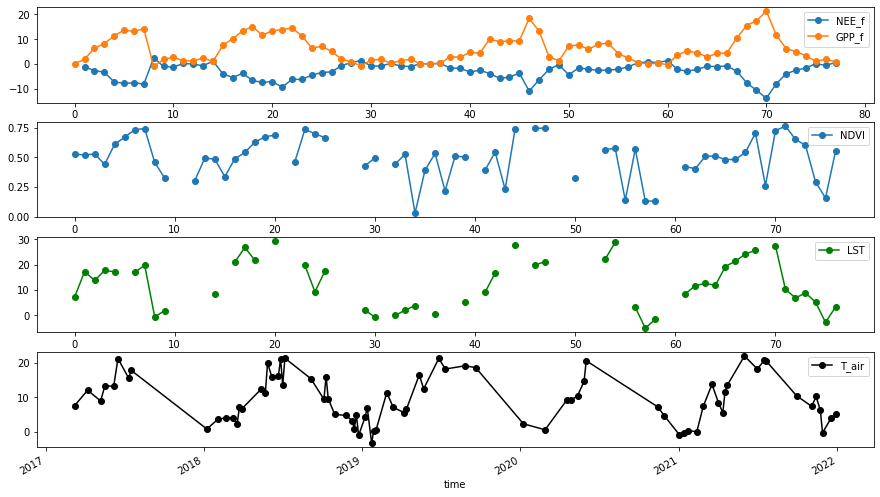

In [40]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(15,9))
Auch_all1.loc[:,['NEE_f','GPP_f']].plot(marker='o', ax=axs[0])
Auch_all1.loc[:,['NDVI']].plot(marker='o', ax=axs[1])
Auch_all1.loc[:,['LST']].plot(marker='o',c='g', ax=axs[2])
Auch_all1.loc[:,['time','T_air']].plot(x='time', marker='o',c='k', ax=axs[3])

<AxesSubplot:title={'center':'Auchencorth_Half_Hour'}>

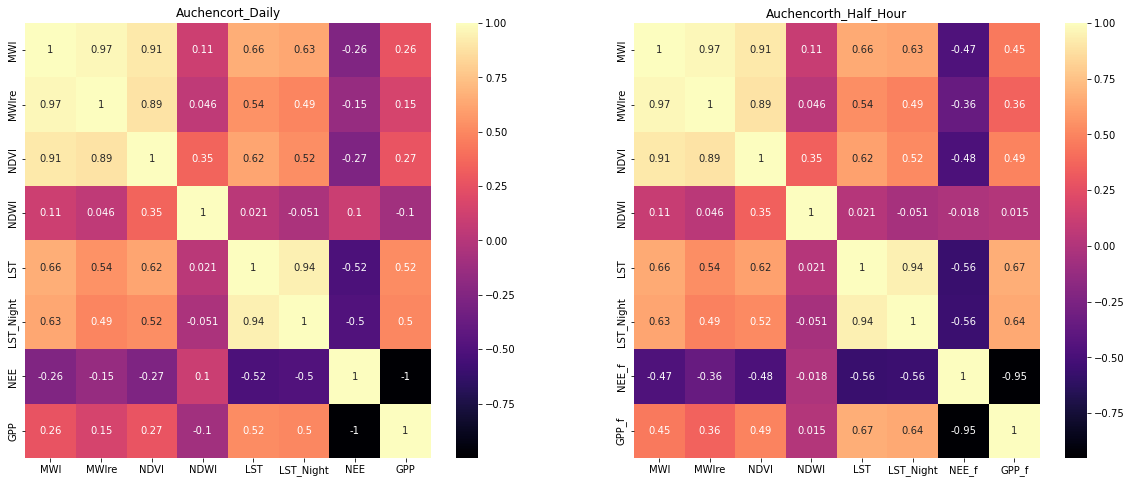

In [106]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

axs[0].set_title('Auchencort_Daily')
sns.heatmap(Auch_all2.corr(), cmap='magma', annot=True, ax=axs[0])
axs[1].set_title('Auchencorth_Half_Hour')
sns.heatmap(Auch_all1.corr(), cmap='magma', annot=True,  ax=axs[1])

<AxesSubplot:title={'center':'Auchencorth_Half_Hour'}>

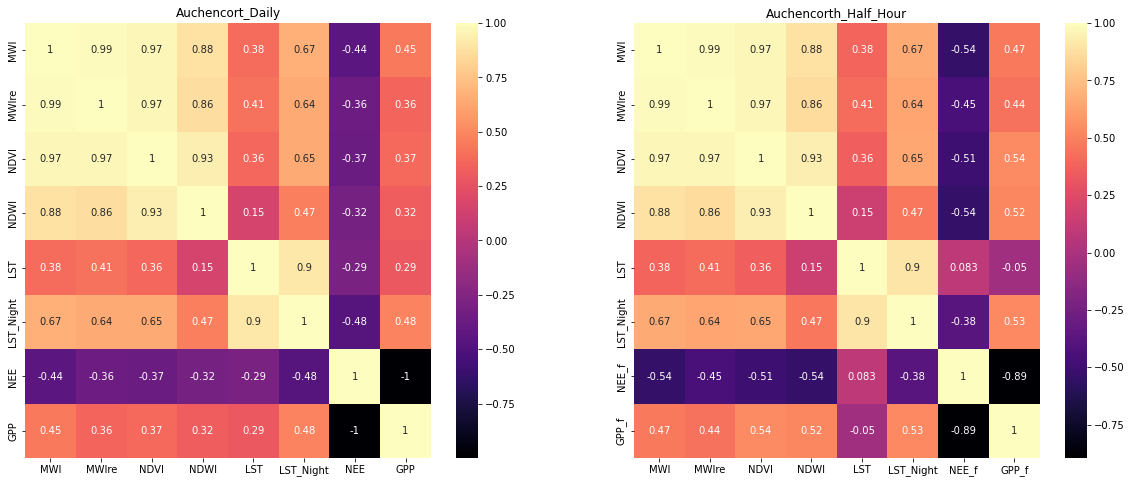

In [108]:
a_corrd = Auch_all2.loc[Auch_all2.time.dt.month.isin([5,6,7,8])].corr()
a_corr = Auch_all1.loc[Auch_all1.time.dt.month.isin([5,6,7,8])].corr()
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

axs[0].set_title('Auchencort_Daily')
sns.heatmap(a_corrd, cmap='magma', annot=True, ax=axs[0])
axs[1].set_title('Auchencorth_Half_Hour')
sns.heatmap(a_corr, cmap='magma', annot=True,  ax=axs[1])

<AxesSubplot:title={'center':'Auchencorth'}>

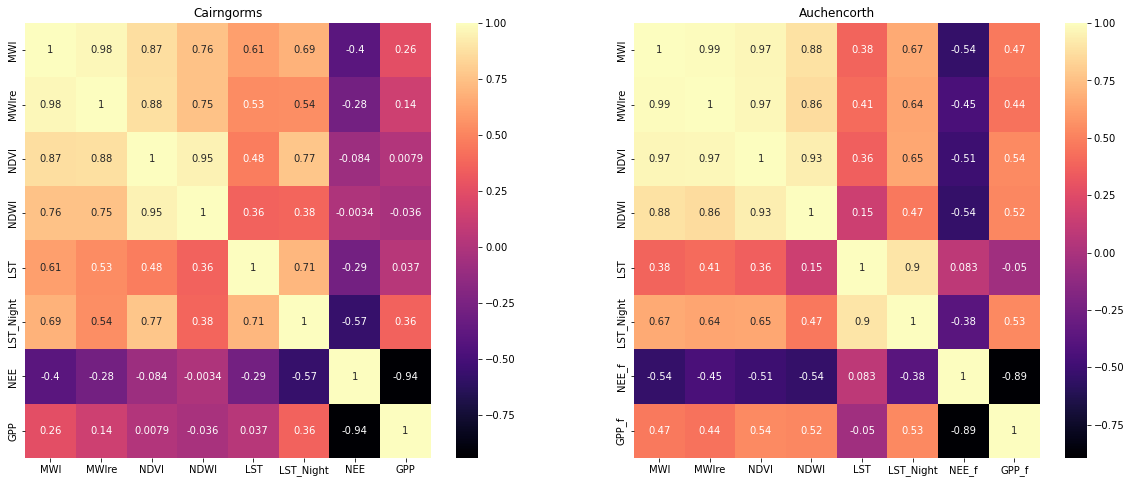

In [60]:
c_corr = Cairn_all1.loc[Cairn_all1.time.dt.month.isin([5,6,7,8])].corr()
a_corr = Auch_all1.loc[Auch_all1.time.dt.month.isin([5,6,7,8])].corr()
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

axs[0].set_title('Cairngorms')
sns.heatmap(c_corr, cmap='magma', annot=True, ax=axs[0])
axs[1].set_title('Auchencorth')
sns.heatmap(a_corr, cmap='magma', annot=True,  ax=axs[1])

### Further clean and transform merged data by scaling and removing gaps

In [41]:
use_Auch = Auch_all1.loc[:,['time','NDVI','LST','NEE_f','GPP_f', 'T_air']]
use_Auch['NDVI_fill'] = use_Auch['NDVI'].interpolate(method='linear', axis=0)
use_Auch['LST_fill'] = use_Auch['LST'].interpolate(method='linear', axis=0)
# use_Auch['LSTan_fill'] = use_Auch['LST_Night'].interpolate(method='linear', axis=0)

In [66]:
use_Auch2 = Auch_all2.loc[:,['time','NDVI','LST','NEE','GPP']]
use_Auch2['NDVI_fill'] = use_Auch2['NDVI'].interpolate(method='linear',limit_direction='both', axis=0)
use_Auch2['LST_fill'] = use_Auch2['LST'].interpolate(method='linear', limit_direction='both', axis=0)
# use_Auch2['LSTan_fill'] = use_Auch2['LST_Night'].interpolate(method='linear', axis=0)

In [67]:
minLST, optLST, maxLST = -2.5, 25, 40
use_Auch2['sNDVI'] = use_Auch2.NDVI_fill - 0.1
ls = np.stack([((use_Auch2.LST_fill-minLST)/(optLST-minLST)).values, ((maxLST-use_Auch2.LST_fill)/(maxLST-optLST)).values])
use_Auch2['sLST'] = np.min(ls, axis=0)
use_Auch2['TG'] = use_Auch2['sNDVI']* use_Auch2['sLST']

In [111]:
use_Cairn = Cairn_all1.loc[:,['time','NDVI','LST','LST_Night','NEE','GPP',T]]
use_Cairn['NDVI_fill'] = use_Cairn['NDVI'].interpolate(method='linear', axis=0)
use_Cairn['LST_fill'] = use_Cairn['LST'].interpolate(method='linear', axis=0)
use_Cairn['LSTn_fill'] = use_Cairn['LST_Night'].interpolate(method='linear', axis=0)

In [43]:
minLST, optLST, maxLST = -2.5, 25, 40
use_Auch['sNDVI'] = use_Auch.NDVI_fill - 0.1
ls = np.stack([((use_Auch.LST_fill-minLST)/(optLST-minLST)).values, ((maxLST-use_Auch.LST_fill)/(maxLST-optLST)).values])
use_Auch['sLST'] = np.min(ls, axis=0)
use_Auch['TG'] = use_Auch['sNDVI']* use_Auch['sLST']

In [26]:
use_Cairn['sNDVI'] = use_Cairn.NDVI_fill - 0.1
ls = np.stack([((use_Cairn.LST_fill-minLST)/(optLST-minLST)).values, ((maxLST-use_Cairn.LST_fill)/(maxLST-optLST)).values])
use_Cairn['sLST'] = np.min(ls, axis=0)
use_Cairn['TG'] = use_Cairn['sNDVI']* use_Cairn['sLST']

<AxesSubplot:xlabel='time'>

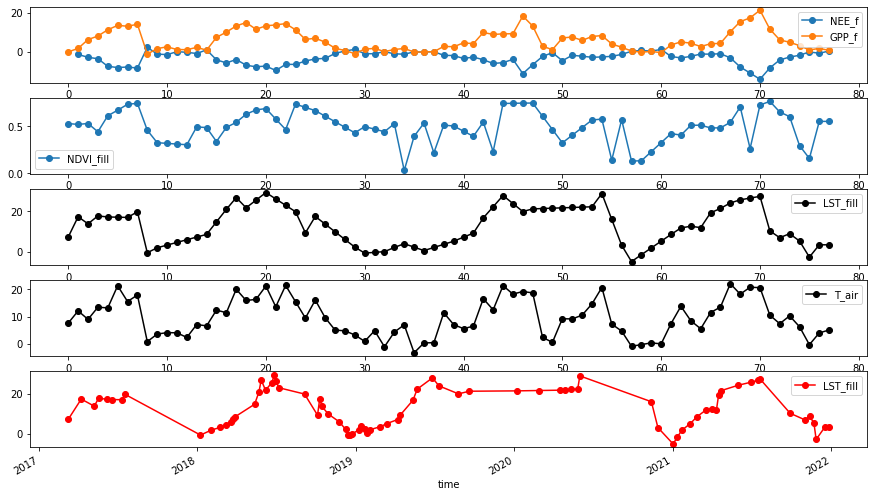

In [44]:

fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(15,9))
use_Auch.loc[:,['NEE_f','GPP_f']].plot(marker='o', ax=axs[0])
use_Auch.loc[:,['NDVI_fill']].plot(marker='o', ax=axs[1])
use_Auch.loc[:,['LST_fill']].plot(marker='o',c='k', ax=axs[2])
use_Auch.loc[:,['T_air']].plot(marker='o',c='k', ax=axs[3])
use_Auch.loc[:,['time','LST_fill']].plot(x='time', marker='o', c='r', ax=axs[4])

In [58]:
use_Auch2.to_csv('AuchData_Daily.csv')

### Develop and calibrate Bayesian Model for estimating gound measured Gross Primary Production (GPP)

In [46]:
X_sNDVI = use_Auch.sNDVI.values
X_sLST = use_Auch.sLST.values
Y_gpp = use_Auch.GPP_f.values

gpp_model = pm.Model()

with gpp_model:
    # Priors 
    # alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=0.5)

    # model 
    mu_gpp = (X_sNDVI*X_sLST)*beta

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu_gpp, sigma=sigma, observed=Y_gpp)
with gpp_model:
    idata = pm.sample(draws=1000, tune=1000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [47]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,24.813,1.062,22.814,26.786,0.018,0.013,3425.0,2687.0,1.0
sigma,2.788,0.168,2.471,3.098,0.003,0.002,3968.0,2663.0,1.0


'GPP_Bayes_TG_10-2022.nc'

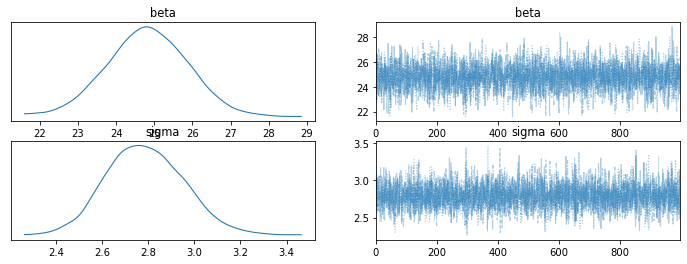

In [75]:
az.plot_trace(idata, combined=True);
idata.to_netcdf('GPP_Bayes_TG_10-2022.nc')

### Evaluating model performance and generate GPP maps

<AxesSubplot:>

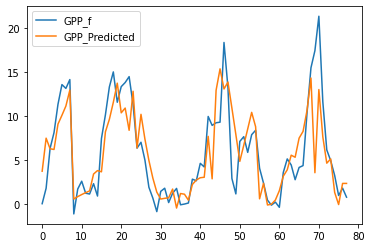

In [49]:
params = idata.posterior
pred_gpp = (xr.DataArray(X_sNDVI, dims=["gpp_obs0"]) * xr.DataArray(X_sLST, dims=["gpp_obs0"])) * params["beta"]
use_Auch['GPP_Predicted'] = pred_gpp.mean(("chain", "draw")).values
use_Auch['GPP_Lower_Quantile']  = pred_gpp.quantile(0.025,("chain", "draw")).values
use_Auch['GPP_Upper_Quantile']  = pred_gpp.quantile(0.975,("chain", "draw")).values
use_Auch.loc[:,['GPP_f', 'GPP_Predicted']].plot()

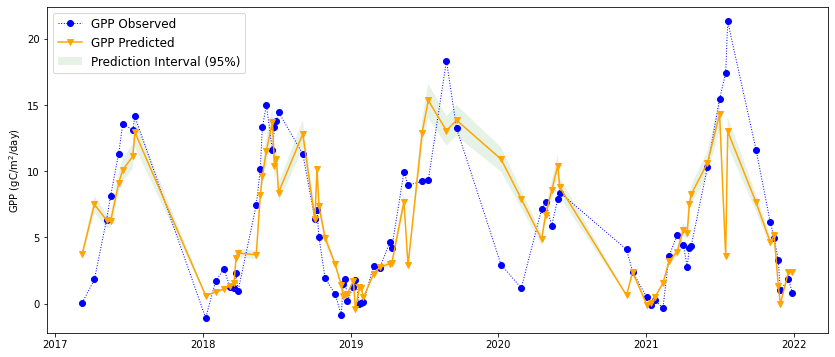

In [76]:
plt.figure(figsize=(14, 6))
plt.plot(use_Auch.time, use_Auch.GPP_f, ls=':', lw=1, color='b', marker='o', label='GPP Observed')
plt.plot(use_Auch.time, use_Auch.GPP_Predicted, color='orange', marker='v', label='GPP Predicted')
plt.ylabel('GPP (gC/m$^2$/day)')
plt.fill_between(use_Auch.time, use_Auch.GPP_Upper_Quantile, use_Auch.GPP_Lower_Quantile, facecolor='green', alpha=0.1, label='Prediction Interval (95%)')
plt.legend(loc='upper left', fontsize=12)

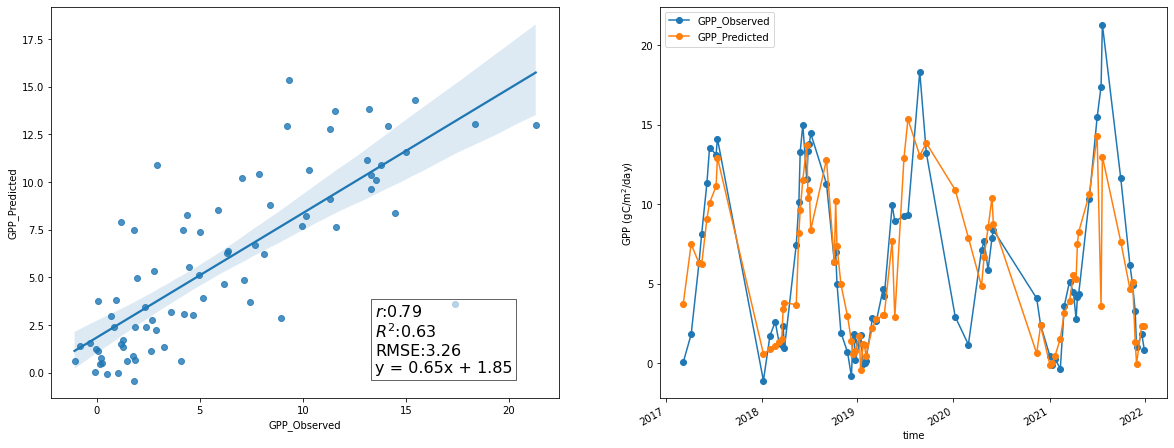

In [135]:
from matplotlib.pyplot import ylabel
use_Auch['GPP_Observed'] = use_Auch.GPP_f

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
reg = sns.regplot(x='GPP_Observed', y='GPP_Predicted', data=use_Auch, ax=axs[0])
use_Auch.loc[:,['time', 'GPP_Observed', 'GPP_Predicted']].plot(x='time', ax=axs[1], ylabel='GPP (gC/m$^2$/day)', marker='o')
cor = use_Auch.loc[:,['GPP_f', 'GPP_Predicted']].corr().values[0,1]
mse = np.sqrt(mean_squared_error(use_Auch.GPP_f, use_Auch.GPP_Predicted))
r2 = r2_score(use_Auch.GPP_f, use_Auch.GPP_Predicted)
out = scipy.stats.linregress(x=reg.get_lines()[0].get_xdata(),y=reg.get_lines()[0].get_ydata())
eqn = f'y = {(out.slope).round(2)}x + {(out.intercept).round(2)}'
txt0 = axs[0].text(x=13.5, y=0, s=f'$r$:{(cor).round(2)}\n$R^2$:{(r2).round(2)}\nRMSE:{(mse).round(2)}\n{eqn}', fontsize=16) 
txt0.set_bbox(dict(facecolor='white', alpha=0.6))

In [ ]:
minLST, optLST, maxLST = -2.5, 25, 40
ls = np.stack([((cube_dat1['LST']-minLST)/(optLST-minLST)).values, ((maxLST-cube_dat1['LST'])/(maxLST-optLST)).values])

In [77]:
Restr_sites = gpd.read_file('PeatRestore_Sites/Site_outlines_combined.shp') 
s1 = Restr_sites[Restr_sites.Site=='Auchencorth Moss P2'].to_crs(crs="epsg:4326")
s1

,Site,Type,Status,geometry
17,Auchencorth Moss P2,Restoration data,Pre-application,"POLYGON ((-3.26681 55.77962, -3.26699 55.77952..."


In [78]:
auch_site = Restr_sites[Restr_sites.Site=='Auchencorth Moss P2'].to_crs(crs="epsg:4326")
auch_ndvi = mask_dataset_by_geometry(cube_dat2, auch_site.geometry.values[0]).load()
auch_lst = mask_dataset_by_geometry(cube_dat1, auch_site.geometry.values[0]).load()


sampleLST = auch_lst.sel(time=(auch_lst.time.dt.date.isin(list(auch_ndvi.time.dt.date.values))))['LST']
sampleNDVI = auch_ndvi.sel(time=(auch_ndvi.time.dt.date.isin(list(sampleLST.time.dt.date.values))))['NDVI']

scaleLST = np.stack([((sampleLST-minLST)/(optLST-minLST)), ((maxLST-sampleLST)/(maxLST-optLST))])
scaleLST = np.min(scaleLST, axis=0)
scaleNDVI = sampleNDVI - 0.1


In [79]:
params2 = idata.posterior
pred_gpp2 = (scaleNDVI * scaleLST) * params2["beta"]
mean_gpp = pred_gpp2.mean(("chain", "draw"))
lower_gpp  = pred_gpp2.quantile(0.025,("chain", "draw"))
upper_gpp  = pred_gpp2.quantile(0.975,("chain", "draw"))

In [111]:
da = mean_gpp
da.assign_attrs(**{'Description':'Mean GPP for Restored Auchenchorth Peatlands', 'units':'gC/m^2/day'})
da.to_dataset(name='GPP', promote_attrs = True)

<xarray.Dataset>
Dimensions:  (lat: 70, lon: 75, time: 94)
Coordinates:
  * lat      (lat) float64 55.79 55.79 55.79 55.79 ... 55.78 55.78 55.78 55.78
  * lon      (lon) float64 -3.272 -3.271 -3.271 -3.271 ... -3.258 -3.258 -3.258
  * time     (time) datetime64[ns] 2016-01-14 2016-03-14 ... 2022-07-16
Data variables:
    GPP      (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

In [112]:
cube_dat1

,Array,Chunk
Bytes,18.62 GiB,4.77 MiB
Shape,"(94, 5491, 9683)","(6, 344, 606)"
Count,4097 Tasks,4096 Chunks
Type,float32,numpy.ndarray


In [131]:
def zarr_cube_from_dataArray(da, quant_type, data_attrs, path_name):
   da = da.dropna(dim='time', how='all')
   x_dat = xr.DataArray(
    data = da.values,
    dims=('time','lat','lon'),
    coords = {'lon':da.lon,
             'lat':da.lat,
             'time':da.time},
    name = f'GPP_{quant_type}',
    attrs= data_attrs
    )
   return x_dat.to_dataset().to_zarr(path_name)



In [132]:
attrs = {'Description':'Mean GPP for Restored Auchenchorth Peatlands', 'units':'gC/m^2/day'}
attrs1 = {'Description':'Upper limit GPP Restored Auchenchorth Peatlands', 'units':'gC/m^2/day'}
attrs2 = {'Description':'Lower limit GPP Restored Auchenchorth Peatlands', 'units':'gC/m^2/day'}

zarr_cube_from_dataArray(mean_gpp, 'mean', attrs, '/media/Cheetah_2/ZARR_files/S2_GPP_Mean_Auchencorth_RS.zarr')
zarr_cube_from_dataArray(upper_gpp, 'upper', attrs1, '/media/Cheetah_2/ZARR_files/S2_GPP_Upper_Auchencorth_RS.zarr')
zarr_cube_from_dataArray(lower_gpp, 'lover', attrs2, '/media/Cheetah_2/ZARR_files/S2_GPP_Lower_Auchencorth_RS.zarr')

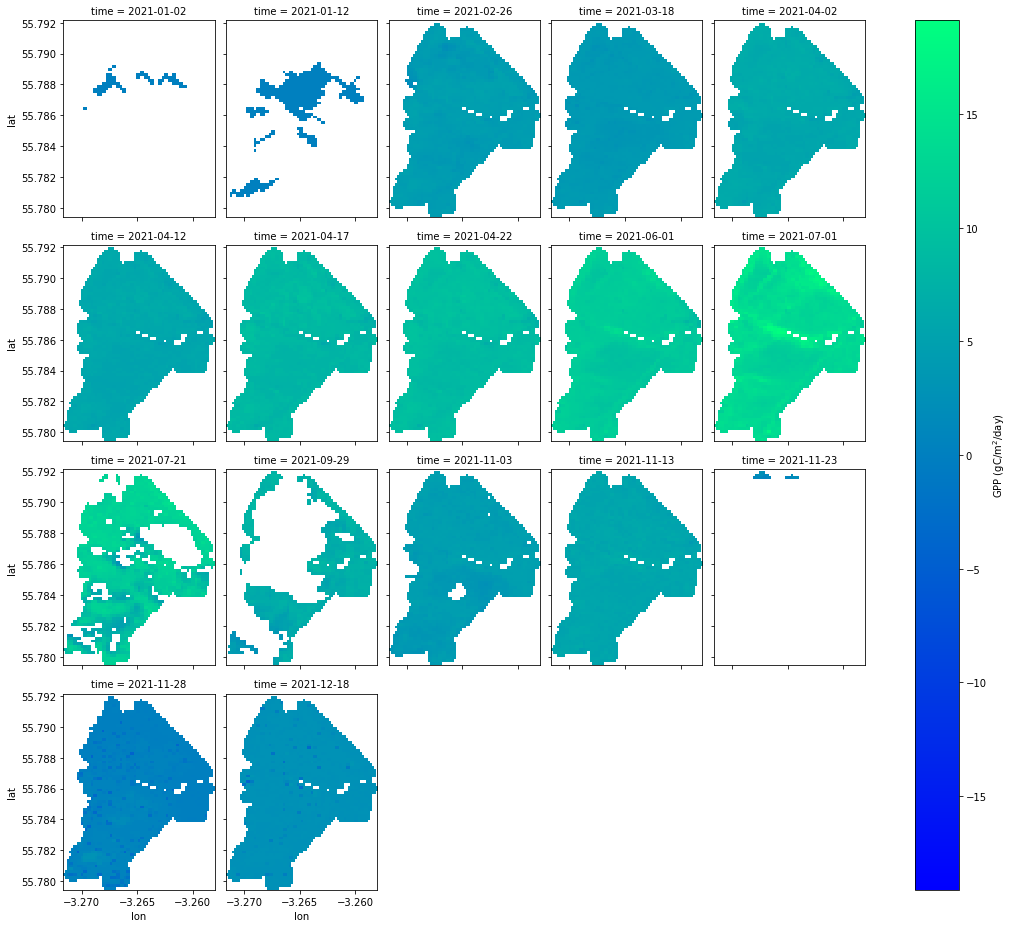

In [134]:
subsel = mean_gpp.sel(time='2021')
# subsel1 = subsel.isel(time=(subsel.time.dt.month.isin([4,5,6])))
subsel.dropna(dim='time', how='all').plot.imshow(col='time', cmap='winter', col_wrap=5, figsize=(15,13), cbar_kwargs={'label':'GPP (gC/m$^2$/day)'})